In [87]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn import metrics
from sklearn.metrics import r2_score


from itertools import combinations

In [91]:


Company = pd.read_csv("Amazon_final.csv",index_col=0)
Google_trends_df = pd.read_csv("./New Data/Google_trends_data_updated.csv",index_col=0)
All = pd.read_csv("All.csv",index_col=0)

# Datetime for Apple
Company.date = pd.to_datetime(Company.date)
Company['Date_date']=Company['date'].apply(lambda x:x.date())
Company.Date_date = pd.to_datetime(Company.Date_date)
Company = Company.set_index('date')
All.index = pd.to_datetime(All.index)
# Adding Zika trends data
Company = pd.concat([Company, Google_trends_df['Covid-19'], Google_trends_df['zika']],axis=1)


Company = Company[2:-1] # from 2011-01-03 to 2020-04-29



Company['time'] = Company.index.to_series().apply(lambda x: x.toordinal())

Company = Company[['company_news','world_news','company_trends','Coronavirus', 'presidential election', 'Lockdown','Pandemic', 'Quarantine'

,'zika','Covid-19','time','Close']]



In [68]:
# slicing for time windows
Covid_19 = Company['2020-01-01':'2020-04-30']
Zika = Company['2015-01-01':'2016-01-01']
election_2016 = Company['2016-06-01':'2017-05-30']
election_2012 = Company['2012-06-01':'2013-05-30']

In [69]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def predict(theta, X):
    return np.dot(X, theta)

def getThetaClosedForm(X,Y):
    theta = np.linalg.inv(X.T@X)@X.T@Y
    return theta

# Covid

In [70]:
df = Covid_19

In [71]:
df.index = pd.to_datetime(df.index)


In [72]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [73]:
cutIdx = int(len(std_df)*0.7)

In [74]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends', 'Coronavirus',
                                                           'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
                                                           'Covid-19', 'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the Covid_19 timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the Covid_19 timewindow: 
                       Coefficient
Coronavirus              -1.067497
time                      0.785169
Covid-19                  0.442738
zika                     -0.188441
Quarantine                0.172803
presidential election     0.169466
Pandemic                  0.143494
Bias_Constant             0.135643
company_trends            0.103721
Lockdown                 -0.072933
world_news                0.065659
company_news             -0.032567


In [75]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [76]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [77]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [78]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [79]:
Names = ['The Lowest root_mean_squared_error of the training set', 'The Lowest neg_mean_squared_error of the training set', 'The Lowest mean_absolute_percentage_error of the training set', 'The Highest R2_score of the training set']


selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

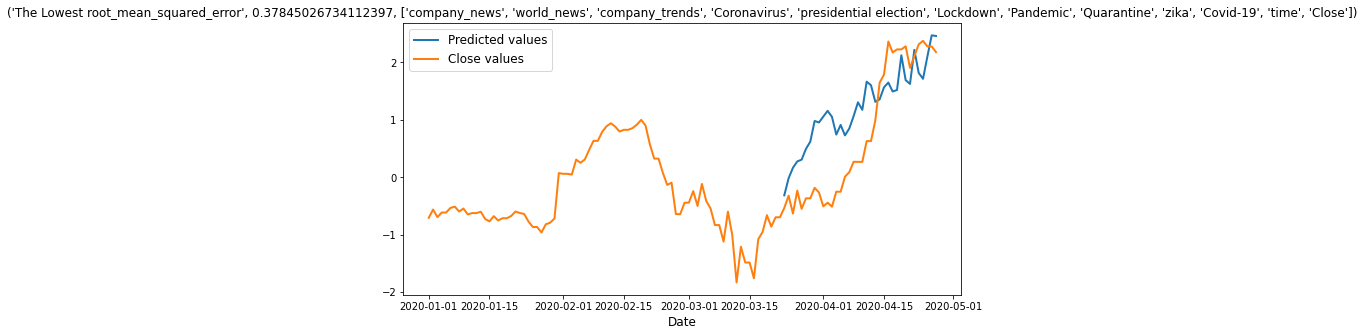

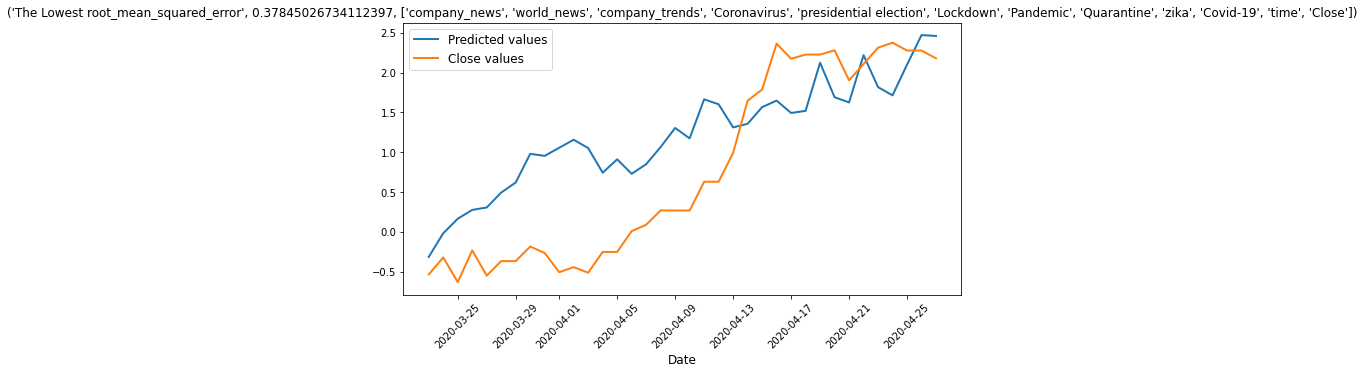

Root_mean_squared_error:  0.828527257838123
neg_mean_squared_error:  -0.6548347572358392
mean_absolute_percentage_error:  366.06285340982885
R2 score:  0.4875303942881677


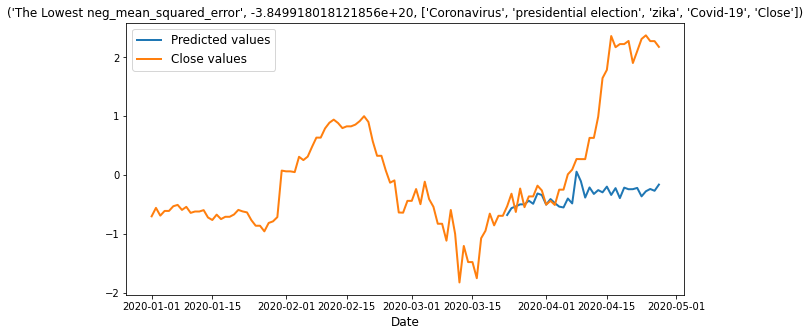

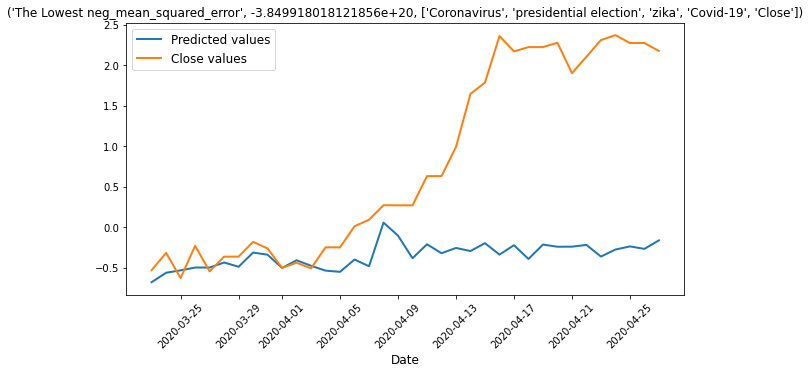

Root_mean_squared_error:  1.5563881039593501
neg_mean_squared_error:  -0.3900454001166127
mean_absolute_percentage_error:  209.02229810841337
R2 score:  -0.8083825858279823


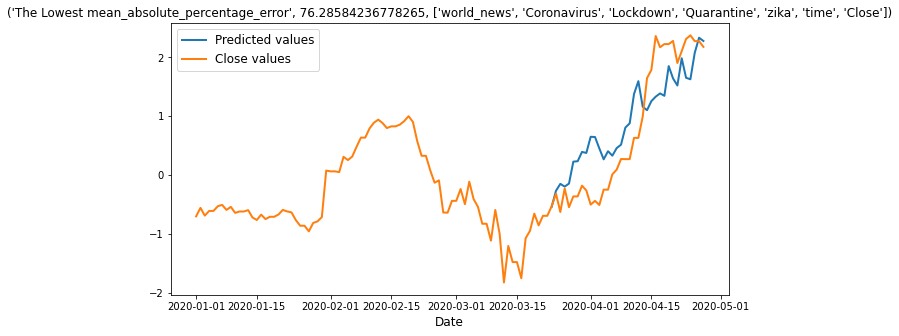

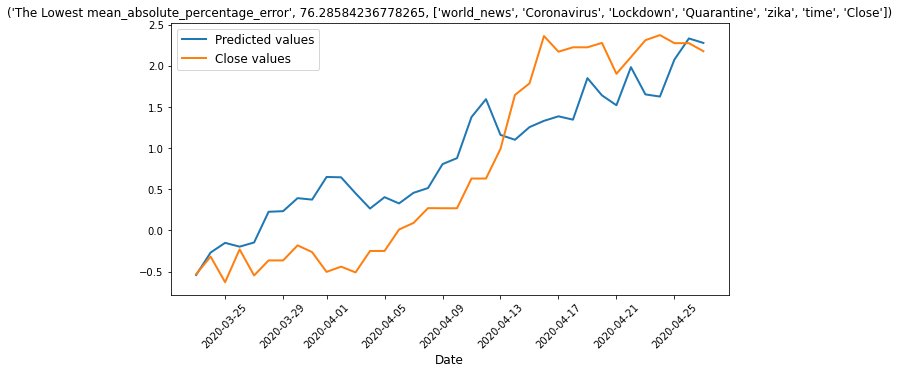

Root_mean_squared_error:  0.6063367430655142
neg_mean_squared_error:  -0.6807537689334985
mean_absolute_percentage_error:  185.018417424486
R2 score:  0.7255379618242748


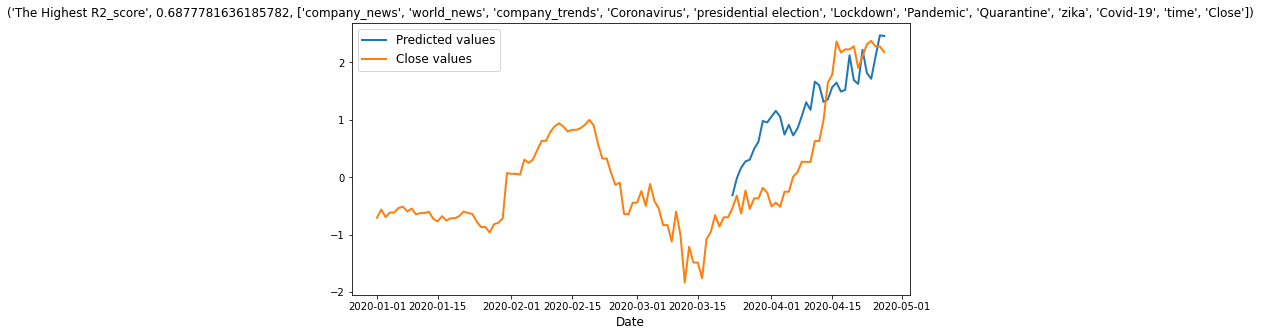

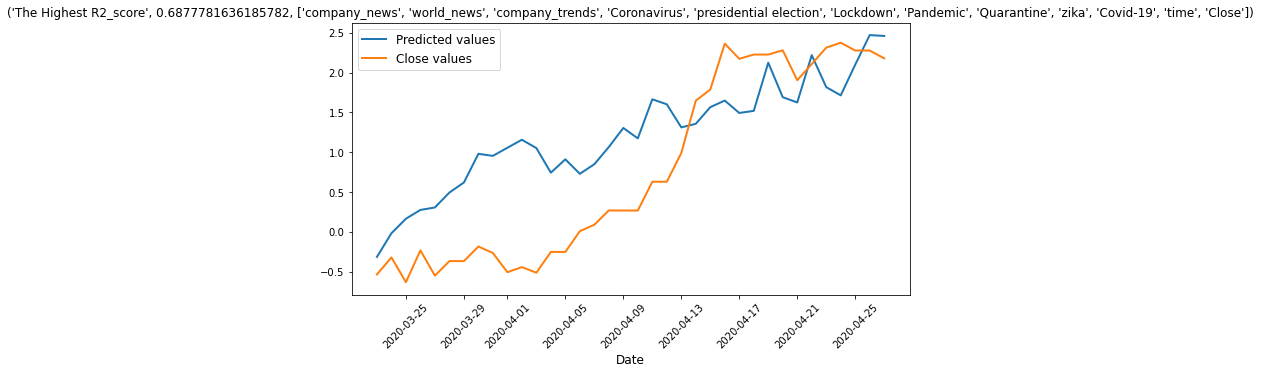

Root_mean_squared_error:  0.828527257838123
neg_mean_squared_error:  -0.6548347572358392
mean_absolute_percentage_error:  366.06285340982885
R2 score:  0.4875303942881677


In [80]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

In [81]:
print("The best performance features:", selected_High_performence_features[2][0])
print("Root_mean_squared_error:  0.6063367430655142")
print('neg_mean_squared_error:  -0.6807537689334985')
print('mean_absolute_percentage_error:  185.018417424486')
print('R2 score:  0.7255379618242748')


The best performance features: ['world_news', 'Coronavirus', 'Lockdown', 'Quarantine', 'zika', 'time', 'Close']
Root_mean_squared_error:  0.6063367430655142
neg_mean_squared_error:  -0.6807537689334985
mean_absolute_percentage_error:  185.018417424486
R2 score:  0.7255379618242748


In [82]:
features_from_other_timewindows_based_on_Coefficients = [[['zika','Lockdown','time','company_news','Close'],"Zika"],
                                                         [['time','Pandemic','Lockdown','company_trends','Close'],'Election 2012'],
                                                         [['time','zika','company_trends','Lockdown','Close'], 'Election 2016']]




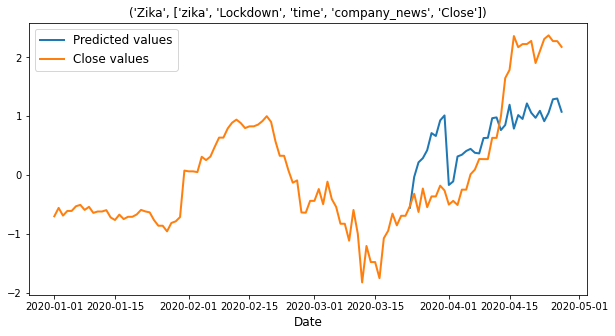

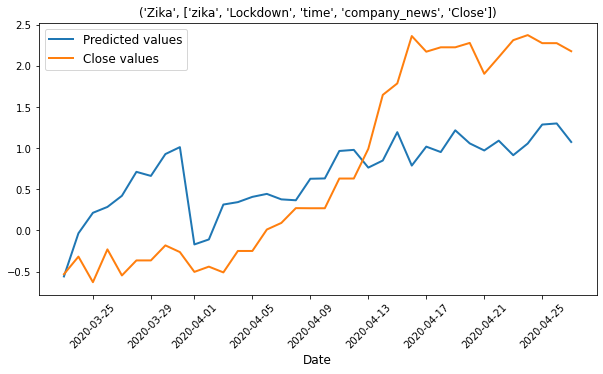

Root_mean_squared_error:  0.8704686613583751
neg_mean_squared_error:  -0.8135766116916887
mean_absolute_percentage_error:  237.79081294475137
R2 score:  0.43433306786537507


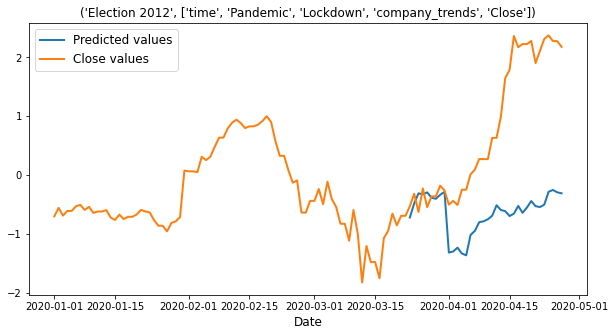

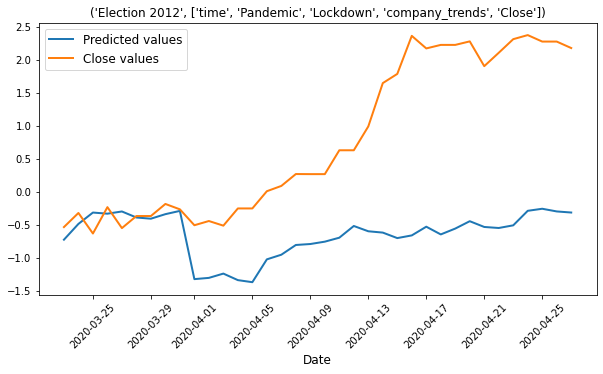

Root_mean_squared_error:  1.7799591476045258
neg_mean_squared_error:  -0.3595963464973565
mean_absolute_percentage_error:  439.8915975115146
R2 score:  -1.365236544400224


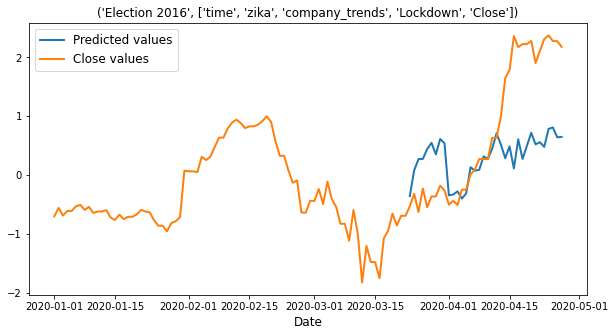

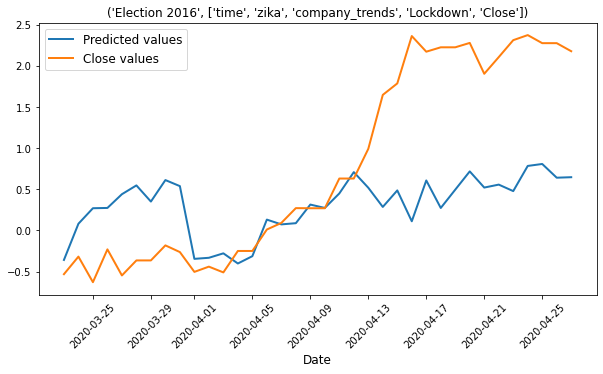

Root_mean_squared_error:  1.093102124356107
neg_mean_squared_error:  -0.2889513430715848
mean_absolute_percentage_error:  123.2701555834546
R2 score:  0.10797713321253577


In [83]:
for k,i in enumerate(features_from_other_timewindows_based_on_Coefficients):

    df_1 = std_df[i[0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0]))
    plt.xticks(rotation=45)
    plt.show()
    
        # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score: ", R2_score)

# Zika

In [19]:
# removing covid_19, coronavirus features which have only 0s.
df = Zika[['company_news', 'world_news', 'company_trends',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
        'time', 'Close']]

In [20]:
df.index = pd.to_datetime(df.index)


In [21]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [22]:
cutIdx = int(len(std_df)*0.7)

In [23]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
        'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the Zika timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the Zika timewindow: 
                       Coefficient
time                      0.813260
zika                      0.240549
Lockdown                  0.038179
company_news              0.035079
Quarantine                0.034190
Bias_Constant            -0.032561
Pandemic                 -0.027047
presidential election    -0.013698
world_news                0.012580
company_trends           -0.003211


In [24]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [25]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [26]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [27]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [28]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

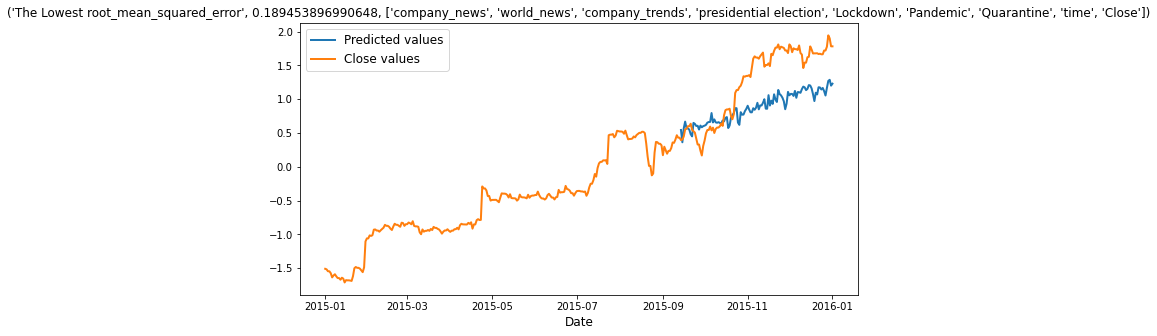

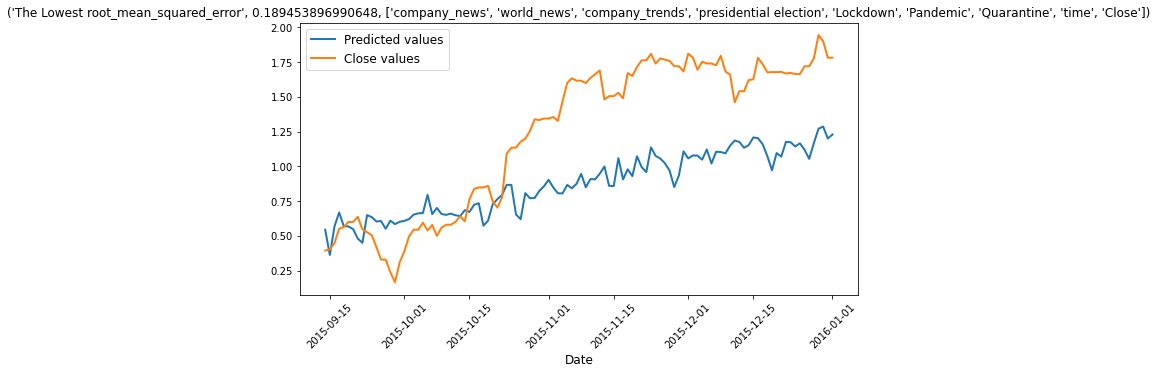

Root_mean_squared_error:  0.5049057189635092
neg_mean_squared_error:  -0.09643702805150352
mean_absolute_percentage_error:  35.99056541797328
R2 score:  0.11069404482706102


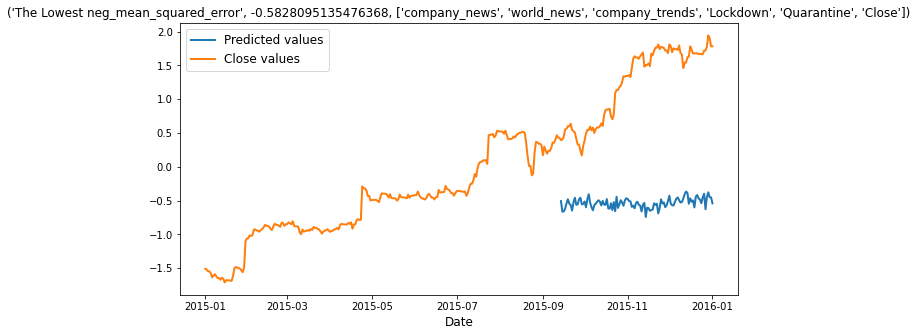

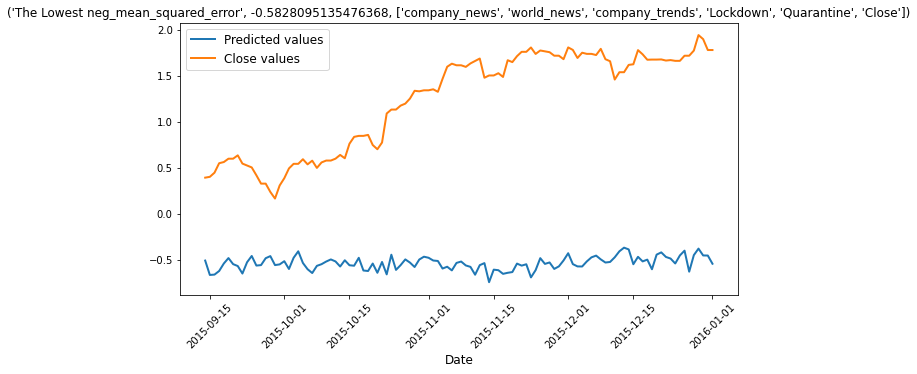

Root_mean_squared_error:  1.8500522768799605
neg_mean_squared_error:  -0.5464540464342477
mean_absolute_percentage_error:  160.89708570242064
R2 score:  -10.939843149469734


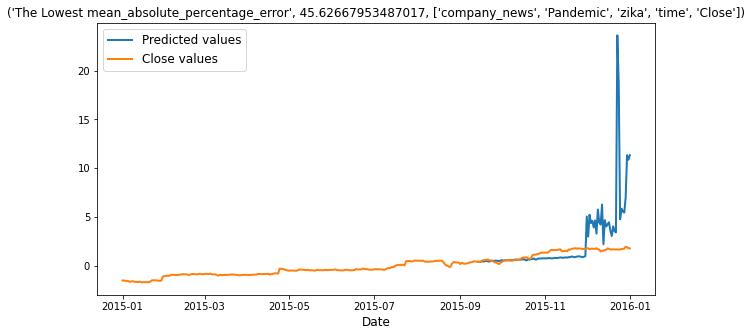

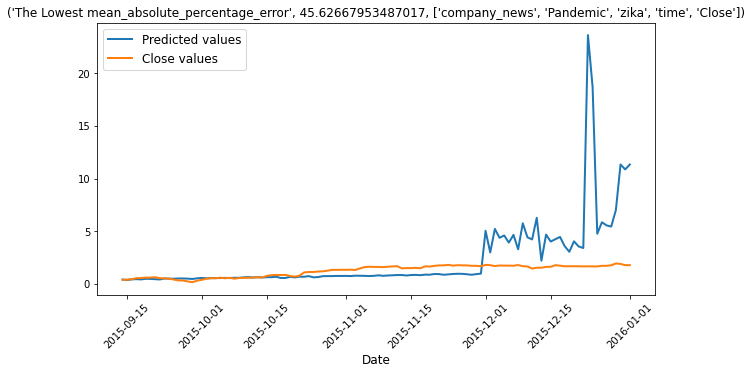

Root_mean_squared_error:  3.4278393806261853
neg_mean_squared_error:  -8.206704255459406e+22
mean_absolute_percentage_error:  99.94964031172493
R2 score:  -39.989398799824656


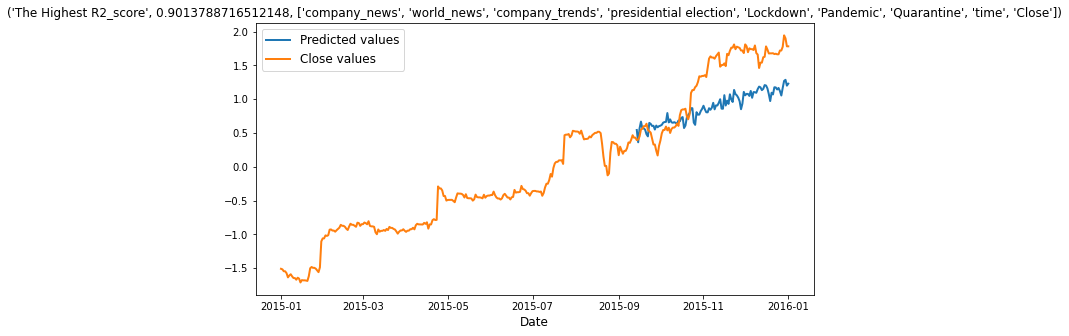

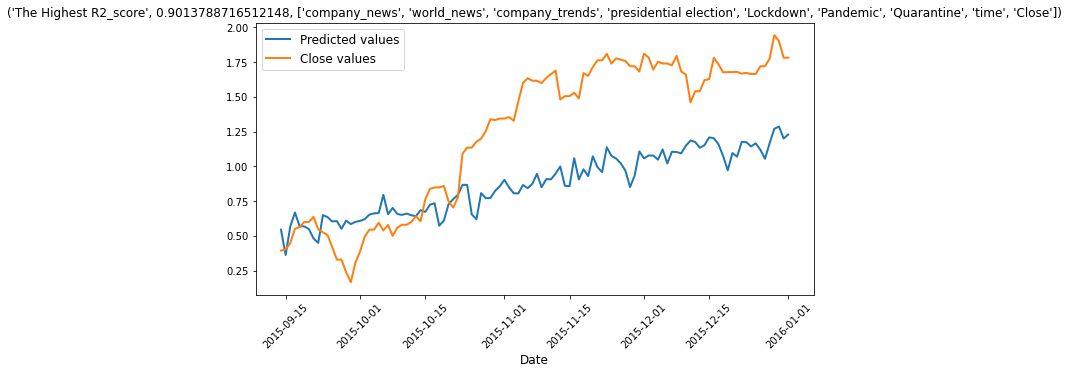

Root_mean_squared_error:  0.5049057189635092
neg_mean_squared_error:  -0.09643702805150352
mean_absolute_percentage_error:  35.99056541797328
R2 score:  0.11069404482706102


In [29]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# Election 2012

In [30]:
# removing covid_19, coronavirus, zika features which have only 0s.
df = election_2012[['company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 
        'time', 'Close']]

In [31]:
df.index = pd.to_datetime(df.index)


In [32]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [33]:
cutIdx = int(len(std_df)*0.7)

In [34]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 
        'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the Election 2012 timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the Election 2012 timewindow: 
                       Coefficient
time                      0.993888
Lockdown                  0.197473
Pandemic                 -0.157997
Bias_Constant             0.139284
company_trends            0.139099
Quarantine                0.072268
presidential election     0.058352
world_news               -0.003644
company_news             -0.000598


In [35]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [36]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [37]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [38]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [39]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

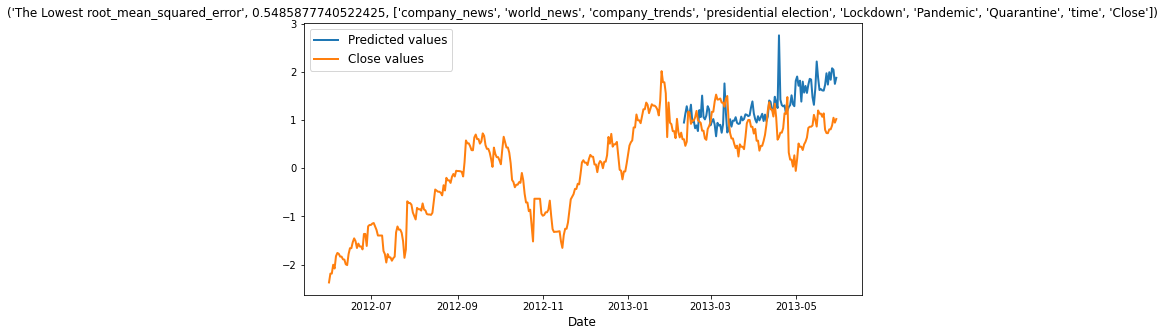

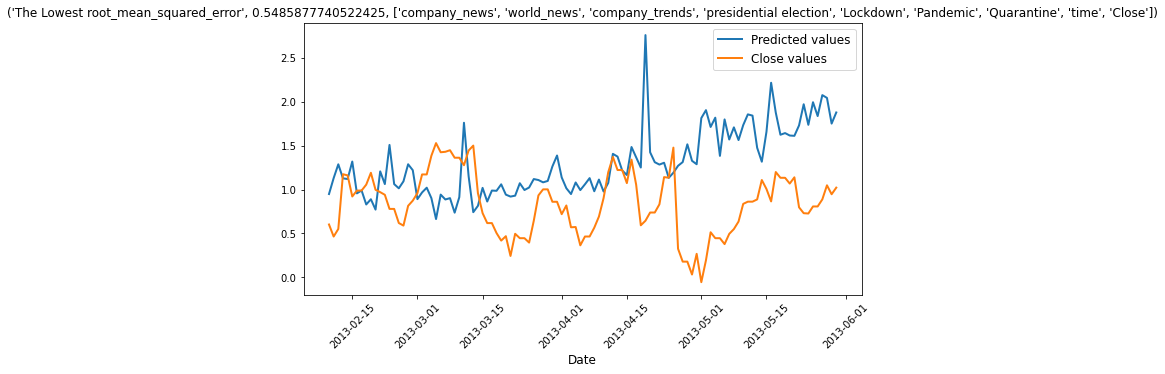

Root_mean_squared_error:  0.7228806057206759
neg_mean_squared_error:  -0.5779838342786131
mean_absolute_percentage_error:  167.2091025433839
R2 score:  -3.246792777819162


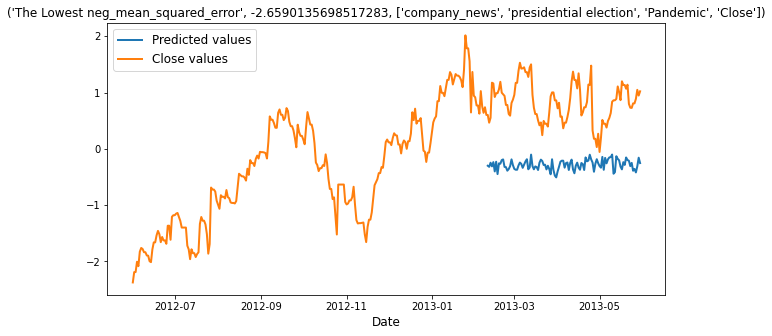

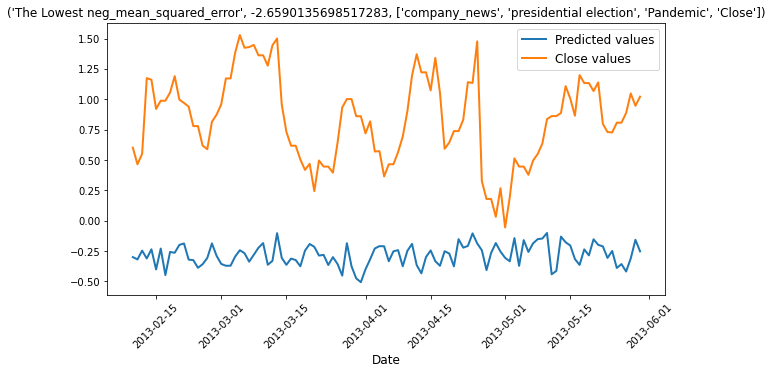

Root_mean_squared_error:  1.1759593010869782
neg_mean_squared_error:  -0.16211966828575167
mean_absolute_percentage_error:  149.3241195140889
R2 score:  -10.23860756874204


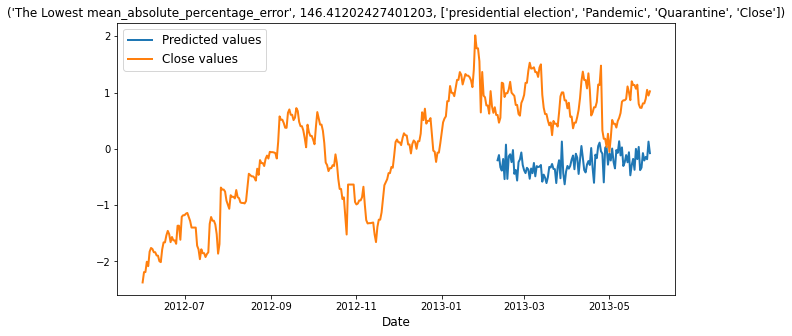

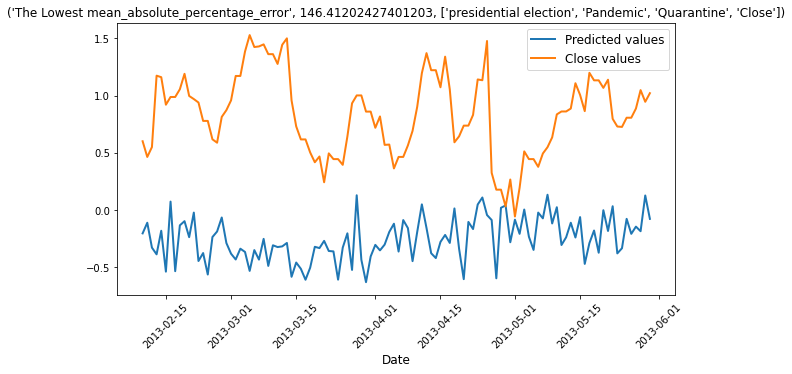

Root_mean_squared_error:  1.1628274497328261
neg_mean_squared_error:  -0.16022904792766413
mean_absolute_percentage_error:  135.51908224752256
R2 score:  -9.989007611382485


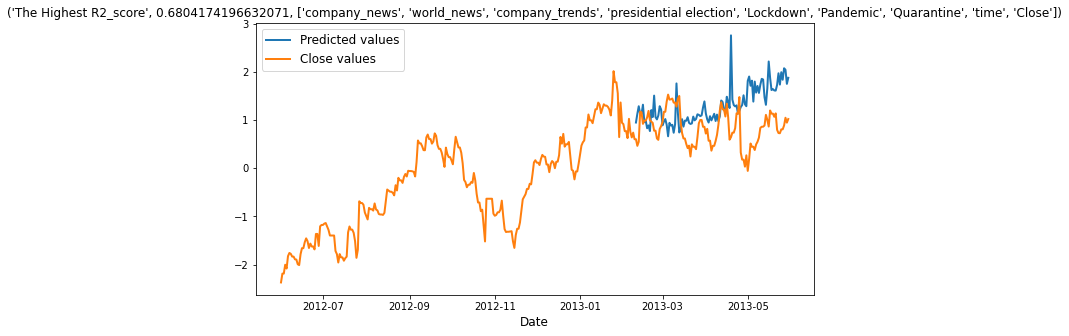

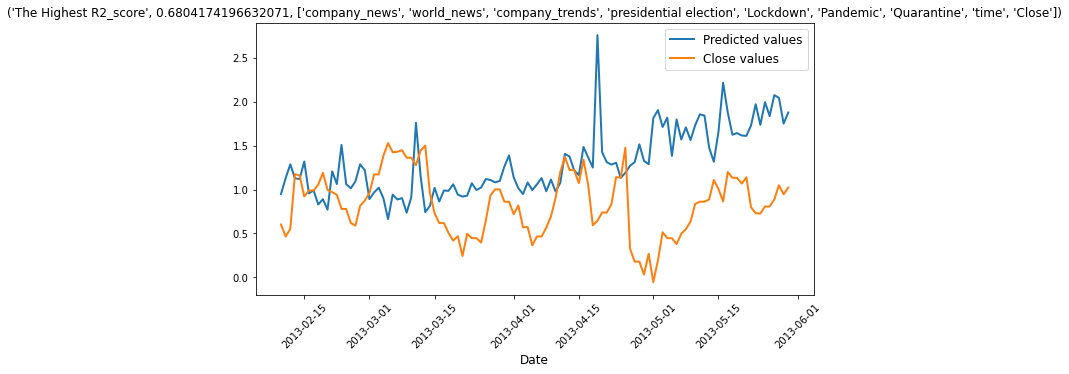

Root_mean_squared_error:  0.7228806057206759
neg_mean_squared_error:  -0.5779838342786131
mean_absolute_percentage_error:  167.2091025433839
R2 score:  -3.246792777819162


In [40]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# Election 2016

In [41]:
# removing covid_19, coronavirus features which have only 0s.
df = election_2016[['company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine','zika',
        'time', 'Close']]

In [42]:
df.index = pd.to_datetime(df.index)


In [43]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [44]:
cutIdx = int(len(std_df)*0.7)

In [45]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends', 
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine','zika',
        'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the Election 2016 timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the Election 2016 timewindow: 
                       Coefficient
time                      0.529580
Bias_Constant            -0.290899
zika                      0.094837
company_trends           -0.075984
Lockdown                  0.067237
Quarantine               -0.045183
company_news              0.025631
presidential election     0.016456
world_news               -0.001277
Pandemic                 -0.000574


In [46]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [47]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [48]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [49]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [50]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

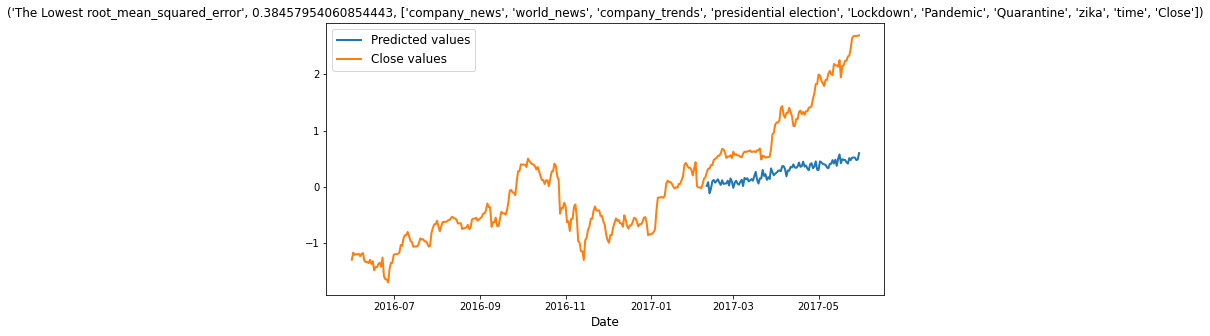

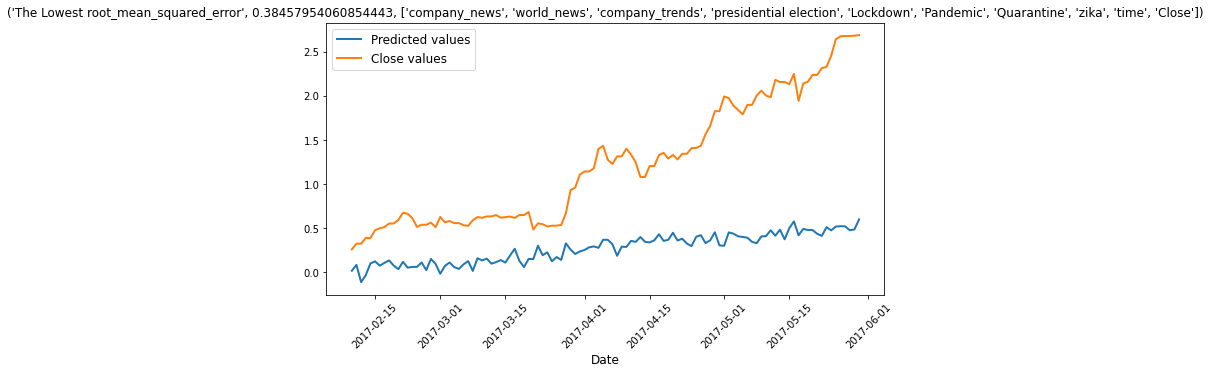

Root_mean_squared_error:  1.11410803922473
neg_mean_squared_error:  -0.08794634106465402
mean_absolute_percentage_error:  78.52887375356921
R2 score:  -1.5172474214107674


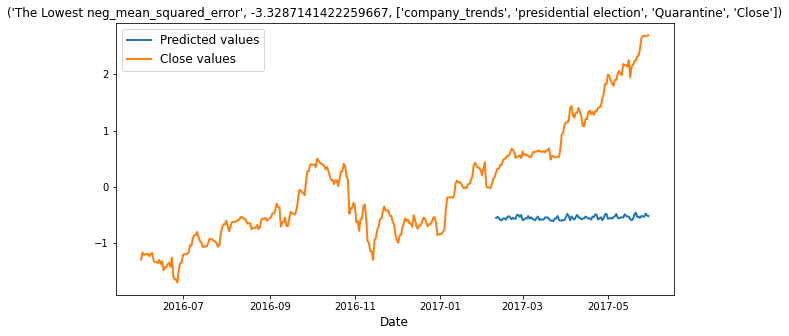

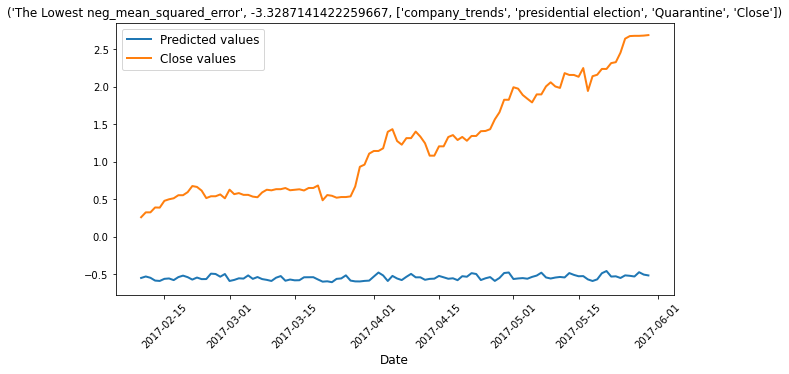

Root_mean_squared_error:  1.9085503003967268
neg_mean_squared_error:  -0.4313010185751874
mean_absolute_percentage_error:  164.12980186219443
R2 score:  -6.387177073555242


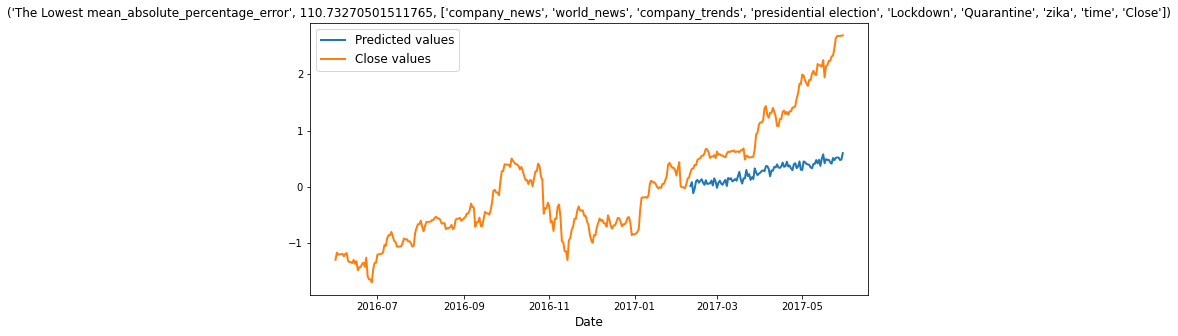

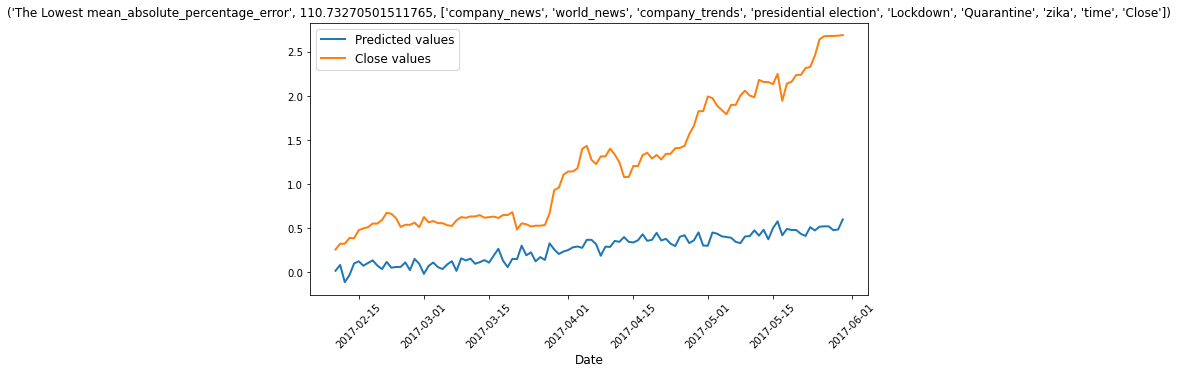

Root_mean_squared_error:  1.1140345855661993
neg_mean_squared_error:  -0.09121330285636217
mean_absolute_percentage_error:  78.50875712024259
R2 score:  -1.5169155057783246


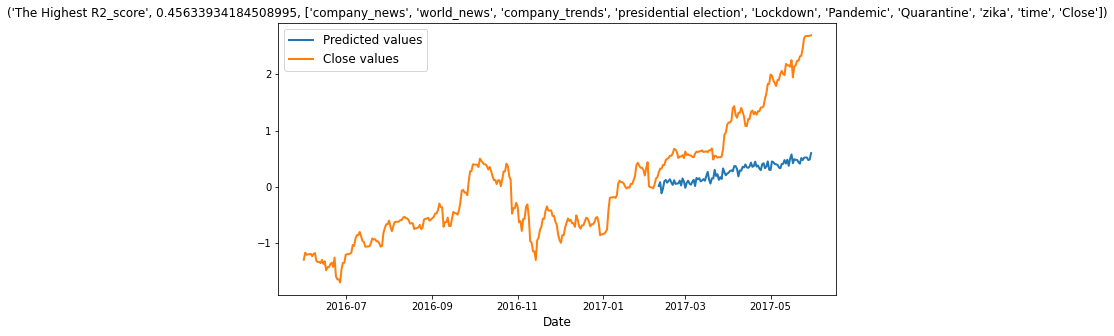

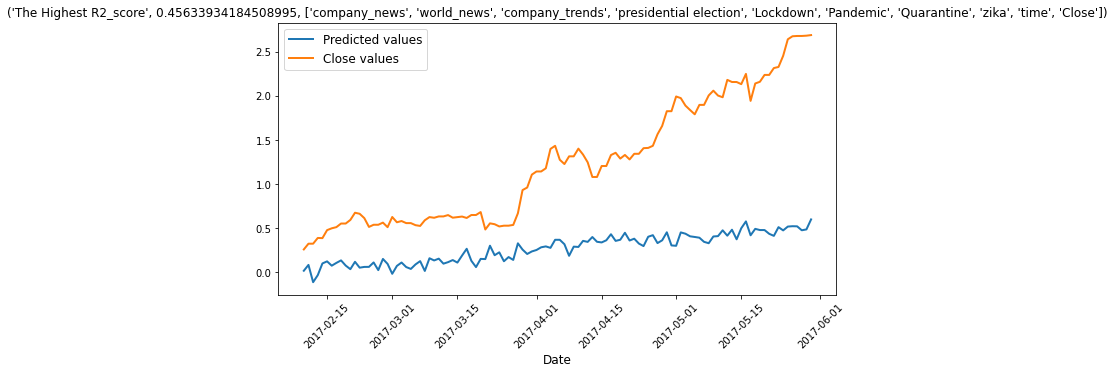

Root_mean_squared_error:  1.11410803922473
neg_mean_squared_error:  -0.08794634106465402
mean_absolute_percentage_error:  78.52887375356921
R2 score:  -1.5172474214107674


In [51]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)

# 10 years

In [52]:
# removing covid_19, coronavirus features which have only 0s.
df = Company


In [53]:
df.index = pd.to_datetime(df.index)


In [54]:
#Standardize training
mean = np.mean(df, axis=0)
std = np.std(df, axis=0, ddof=1)
std_df = (df-mean)/std

In [55]:
cutIdx = int(len(std_df)*0.7)

In [56]:
X_train = std_df.drop('Close', axis=1)[:cutIdx]
y_train = std_df['Close'][:cutIdx]

# adding Bias
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])

theta = getThetaClosedForm(X_train,y_train)
coefficient_df_scratch = pd.DataFrame(data = theta, index =["Bias_Constant",
                                                            'company_news', 'world_news', 'company_trends', 'Coronavirus',
       'presidential election', 'Lockdown', 'Pandemic', 'Quarantine', 'zika',
       'Covid-19', 'time'], columns = ["Coefficient"] )

# coefficient_df_scratch.sort_values(by=['Coefficient'], axis=0, ascending=False)

# coefficient_df_scratch.iloc[(coefficient_df_scratch['Coefficient'].abs()).argsort()]

print("Coefficients of the 10 years timewindow: ")
print(coefficient_df_scratch.iloc[(-coefficient_df_scratch['Coefficient'].abs()).argsort()])

Coefficients of the 10 years timewindow: 
                       Coefficient
Covid-19                  2.369269
time                      0.502283
Quarantine               -0.454376
Coronavirus               0.271283
Pandemic                  0.157047
company_trends           -0.041262
Bias_Constant            -0.036489
Lockdown                 -0.036259
zika                      0.028662
company_news             -0.008295
presidential election     0.001807
world_news               -0.001758


In [57]:
lists = list(std_df.columns)

lists.remove('Close') 

len_lists = len(lists)

target = ['Close']


In [58]:
# getting all combinations of features
lists_features = []
for i in range(len_lists):
    combs = list(combinations(lists,(i+1)))
#     print(combs)
    for k in combs:
        tuple_to_lists = list(k)
        tuple_to_lists.append('Close')
#         print(tuple_to_lists)
        lists_features.append(tuple_to_lists)

In [59]:
# getting PERFORMANCE_Scores of trainning for all combinations of features

features_PERFORMANCE_Scores = []
for features in lists_features:
    df_1 = std_df[features]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]
    
    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
    

    theta = getThetaClosedForm(X_train,y_train)
    
    Y_hat = predict(theta, X_train)

    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_train, Y_hat))
#     print("mean_squared_error: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_train, y_train, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
#     print("neg_mean_squared_error: ",NMSE)
    MAPE_score = MAPE(y_train,Y_hat)
#     print("mean_absolute_percentage_error: ", MAPE_score )
    R2_score = r2_score(y_train,Y_hat)
#     print("R2 score: ", R2_score)
    features_PERFORMANCE_Scores.append([features,RMSE,NMSE,MAPE_score,R2_score])

In [60]:
# getting High_performence_features
selected_High_performence_features = []

for i in range(4):
    if i==3:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1],reverse=True)
    else:
        features_PERFORMANCE_Scores.sort(key=lambda x: x[i+1])
        
    selected_High_performence_features.append(features_PERFORMANCE_Scores[0])

In [61]:
# Names = ['The Lowest root_mean_squared_error', 'The Lowest neg_mean_squared_error', 'The Lowest mean_absolute_percentage_error', 'The Highest R2_score']

selected_High_performence_features_names = []
for f,n in zip(selected_High_performence_features, Names):
    k = [f,n]
    selected_High_performence_features_names.append(k)

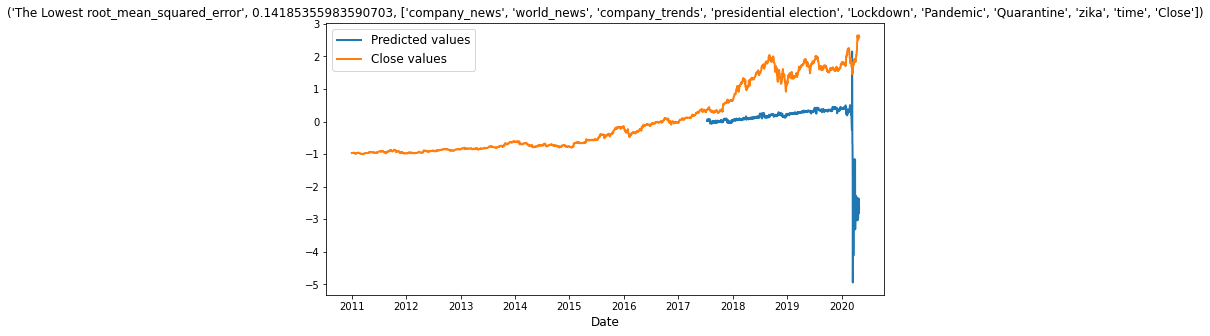

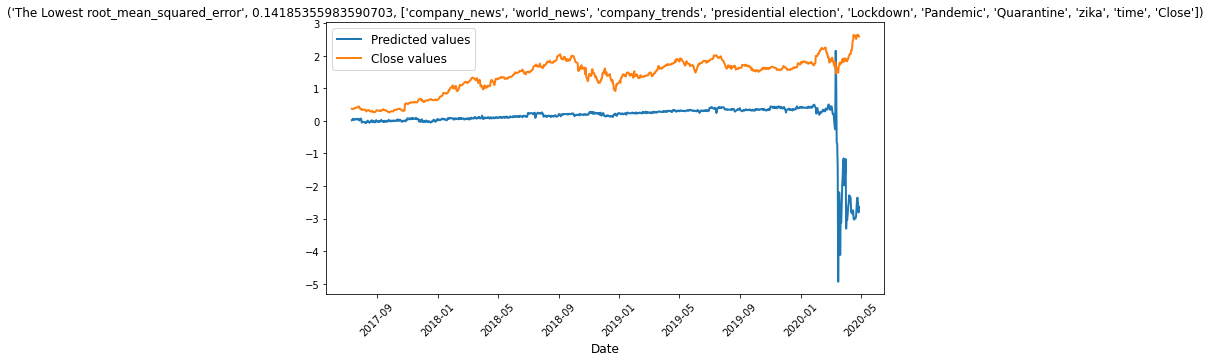

Root_mean_squared_error:  1.5503347040386288
neg_mean_squared_error:  -16.444723462505227
mean_absolute_percentage_error:  93.43665539394985
R2 score:  -7.7512258048790095


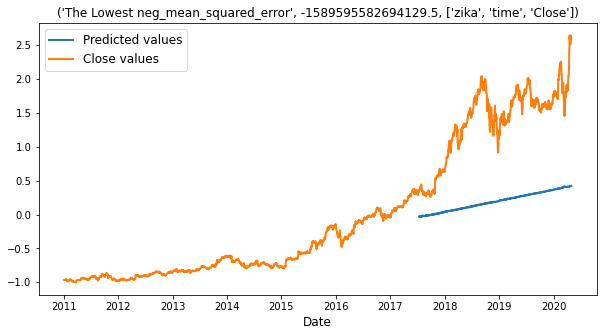

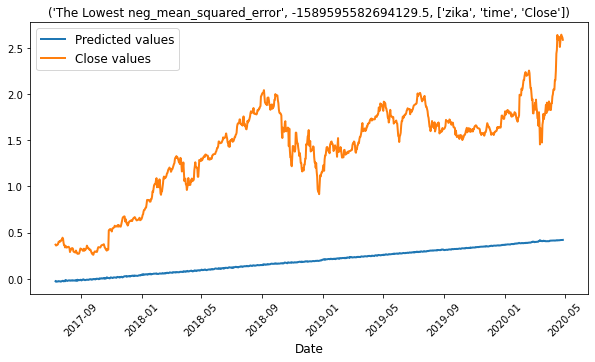

Root_mean_squared_error:  1.2653694593646017
neg_mean_squared_error:  -0.17306313283548164
mean_absolute_percentage_error:  88.4799096887397
R2 score:  -4.829786481997941


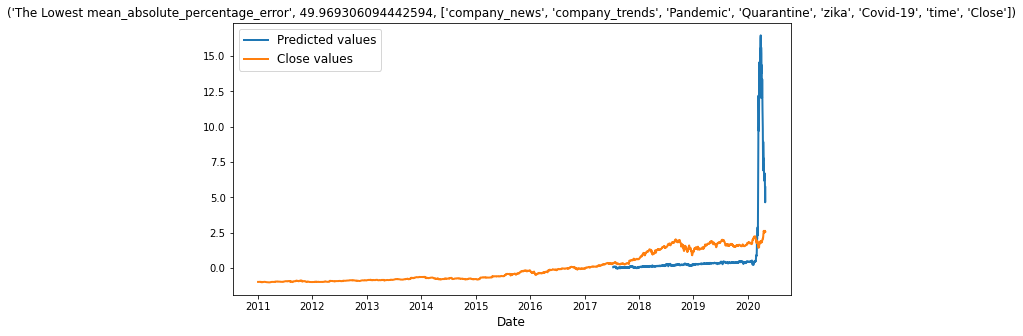

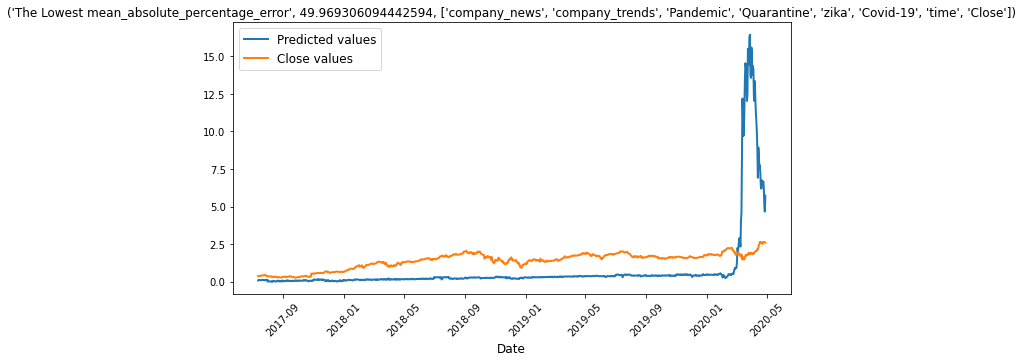

Root_mean_squared_error:  2.3560982983331886
neg_mean_squared_error:  -339485177518505.56
mean_absolute_percentage_error:  99.79126638849816
R2 score:  -19.21178936452801


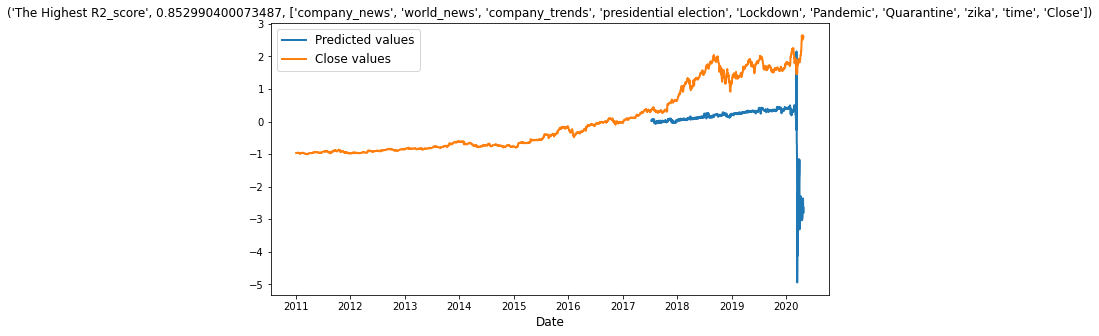

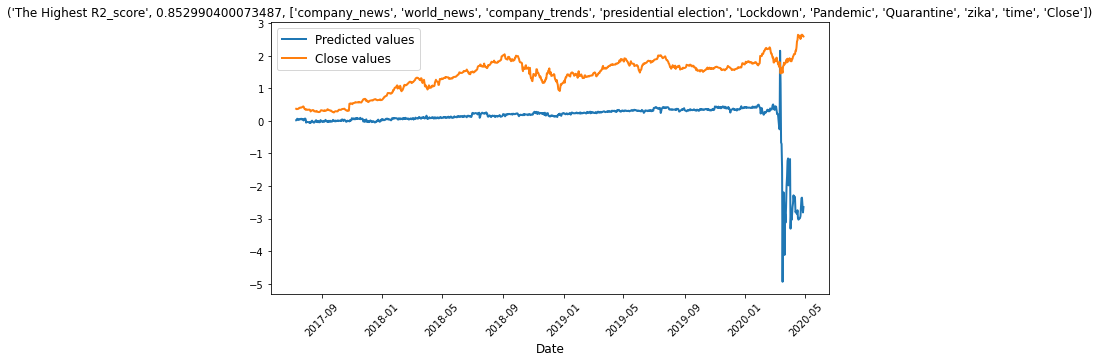

Root_mean_squared_error:  1.5503347040386288
neg_mean_squared_error:  -16.444723462505227
mean_absolute_percentage_error:  93.43665539394985
R2 score:  -7.7512258048790095


In [62]:
for k,i in enumerate(selected_High_performence_features_names):

    df_1 = std_df[i[0][0]]
    X_train, X_test = df_1.drop('Close', axis=1)[:cutIdx], df_1.drop('Close', axis=1)[cutIdx:]
    y_train, y_test = df_1['Close'][:cutIdx], df_1['Close'][cutIdx:]

    # pandas dataframe to numpy array
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()

    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    # adding Bias
    X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
    X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])


    theta = getThetaClosedForm(X_train,y_train)

    Y_hat = predict(theta, X_test)
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df.index, std_df['Close'], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.show()
    
    
    plt.figure(figsize=(10, 5))
    plt.plot(std_df[cutIdx:].index, Y_hat, label = 'Predicted values', linewidth=2)
    # plt.plot(std_df_1[['time']][cutIdx:].index, std_df_1[['Close']][cutIdx:], label = 'True vales', linewidth=2)
    plt.plot(std_df[cutIdx:].index, std_df['Close'][cutIdx:], label = 'Close values', linewidth=2)

    plt.legend(loc = 'best', fontsize = 12)
    plt.xlabel('Date', fontsize = 12)
    plt.title((i[-1],i[0][k+1],i[0][0]))
    plt.xticks(rotation=45)
    plt.show()
    
    # check perfromance score
    RMSE = sqrt(mean_squared_error(y_test, Y_hat))
    print("Root_mean_squared_error of the testing set: ",RMSE)

    scores_lr = cross_val_score(LinearRegression(), 
                                X_test, y_test, 
                                cv=TimeSeriesSplit(n_splits=10),
                                scoring="neg_mean_squared_error")
    NMSE = np.mean(scores_lr)
    print("neg_mean_squared_error of the testing set: ",NMSE)
    MAPE_score = MAPE(y_test,Y_hat)
    print("mean_absolute_percentage_error of the testing set: ", MAPE_score )
    R2_score = r2_score(y_test,Y_hat)
    print("R2 score of the testing set: ", R2_score)